# Analysis of TELL and GCAM-USA's State Load Time Series

This notebook analyzes the time series of annual total and annual peak loads from the GCAM-USA and TELL runs.

In [1]:
# Start by importing the packages we need:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Set the Directory Structure

In [2]:
# Identify the top-level directory and the subdirectory where the data will be stored:
data_input_dir =  '/Users/burl878/Documents/IMMM/Data/TELL/Production_Runs/tell_data/'
data_output_dir =  '/Users/burl878/Documents/Code/code_repos/exp_group_b_test/analyses/data/'
image_output_dir =  '/Users/burl878/Documents/Code/code_repos/exp_group_b_test/analyses/plots/gcam_tell_load_analysis/'

# If the "image_output_dir" subdirectory doesn't exist then create it:
if not os.path.exists(image_output_dir):
   os.makedirs(image_output_dir)


## Process the GCAM-USA Output File

In [11]:
# Read in the 'gcamDataTable_aggParam.csv' file:
gcam_df = pd.read_csv(data_input_dir + '/gcamusa_data/' + 'gcamDataTable_aggParam.csv')

# Subset the data to only the total annual demand for electricity by state:
gcam_df = gcam_df[gcam_df['param'].isin(['elecFinalBySecTWh'])]

# Rename the columns to add the units to each variable:
gcam_df.rename(columns={'subRegion': 'state',
                        'x': 'year',
                        'value': 'load_TWh'}, inplace=True)

# Convert the year variable to an integer:
gcam_df['year'] = gcam_df['year'].astype(int)

# Only keep the columns that are needed:
gcam_df = gcam_df[['scenario', 'state', 'year', 'load_TWh']].copy()

# Initiate an empty normalized load variable:
gcam_df['load_normalized'] = np.nan

# Loop over the rows of the dataframe normalize the load by the base year value:
for row in range(len(gcam_df)):
    # Find the value to normalize by:
    base_load = gcam_df['load_TWh'].loc[(gcam_df['year'] == 2020) & (gcam_df['state'] == gcam_df['state'].iloc[row]) & (gcam_df['scenario'] == gcam_df['scenario'].iloc[row])].values
    
    # Compute the normalized load:
    gcam_df['load_normalized'].iloc[row] = (gcam_df['load_TWh'].iloc[row] / base_load).round(3)
    
    # Clean up
    del base_load

# Write out the dataframe to a .csv file:
gcam_df.to_csv((os.path.join(data_output_dir, 'GCAM_Load_Time_Series.csv')), sep=',', index=False)
    
gcam_df


/var/folders/2x/xdz7fwts5fj0gdl0b7lbtc_cbqnqwx/T/ipykernel_57966/3151532374.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gcam_df['load_normalized'].iloc[row] = (gcam_df['load_TWh'].iloc[row] / base_load).round(3)


,scenario,state,year,load_TWh,load_normalized
135,rcp85cooler_ssp3,AK,1975,0.510868,0.068
136,rcp85cooler_ssp3,AK,1990,4.967655,0.660
137,rcp85cooler_ssp3,AK,2005,6.583501,0.875
138,rcp85cooler_ssp3,AK,2010,6.881499,0.914
139,rcp85cooler_ssp3,AK,2015,6.709779,0.891
...,...,...,...,...,...
148147,rcp45hotter_ssp5,WY,2080,37.512066,2.366
148148,rcp45hotter_ssp5,WY,2085,39.437114,2.488
148149,rcp45hotter_ssp5,WY,2090,41.282365,2.604
148150,rcp45hotter_ssp5,WY,2095,42.812792,2.701


## Process the TELL Output Files

In [10]:
scenarios = ['rcp45cooler_ssp3', 'rcp45cooler_ssp5', 'rcp45hotter_ssp3', 'rcp45hotter_ssp5', 'rcp85cooler_ssp3', 'rcp85cooler_ssp5', 'rcp85hotter_ssp3', 'rcp85hotter_ssp5']

#Initiate a counter to store the results:
counter = 0;
output_df = pd.DataFrame()

# Loop over the scenarios and process each time series:
for s in range(len(scenarios)):
    # Loop over the years from 2020 to 2095 in 5 year increments:
    for year in range(2020,2099,5):
        # Read in the TELL state output file for that year and scenario:
        tell_df = pd.read_csv(data_input_dir + '/outputs/tell_output/' + scenarios[s] + '/' + str(year) + '/TELL_State_Hourly_Load_Data_' + str(year) + '_Scaled_' + str(year) + '.csv')
             
        # Make a list of all of the states in the 'tell_df':
        states = tell_df['State_Name'].unique()
         
        # Loop over the entities and calculate the mean bias for each entity:
        for i in range(len(states)):
            # Iterate the counter by one:
            counter = counter + 1
            
            # Subset to just the data for the entity being processed:
            subset_df = tell_df[tell_df['State_Name'].isin([states[i]])].copy()
          
            # Put the output in a new dataframe:
            output_df.loc[counter, 'scenario'] = scenarios[s]
            output_df.loc[counter, 'year'] = year
            output_df.loc[counter, 'state'] = states[i]
            output_df.loc[counter, 'load_TWh'] = (subset_df['Scaled_TELL_State_Load_MWh'].sum() * 0.000001).round(6)
            output_df.loc[counter, 'peak_load_MWh'] = subset_df['Scaled_TELL_State_Load_MWh'].max()
            
            # Clean up
            del subset_df

        # Clean up
        del tell_df, states
             
# Initiate an empty normalized load variable:
output_df['load_normalized'] = np.nan
output_df['peak_load_normalized'] = np.nan

# Loop over the rows of the dataframe normalize the load by the base year value:
for row in range(len(output_df)):
    # Find the mean value to normalize by:
    base_load = output_df['load_TWh'].loc[(output_df['year'] == 2020) & (output_df['state'] == output_df['state'].iloc[row]) & (output_df['scenario'] == output_df['scenario'].iloc[row])].values
    
    # Compute the mean normalized load:
    output_df['load_normalized'].iloc[row] = (output_df['load_TWh'].iloc[row] / base_load).round(3)
    
    # Find the peak value to normalize by:
    peak_load = output_df['peak_load_MWh'].loc[(output_df['year'] == 2020) & (output_df['state'] == output_df['state'].iloc[row]) & (output_df['scenario'] == output_df['scenario'].iloc[row])].values
    
    # Compute the mean normalized load:
    output_df['peak_load_normalized'].iloc[row] = (output_df['peak_load_MWh'].iloc[row] / peak_load).round(3)
    
    # Clean up
    del base_load, peak_load

# Write out the dataframe to a .csv file:
output_df.to_csv((os.path.join(data_output_dir, 'TELL_Load_Time_Series.csv')), sep=',', index=False)
    
output_df


/var/folders/2x/xdz7fwts5fj0gdl0b7lbtc_cbqnqwx/T/ipykernel_57966/4177318606.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_df['load_normalized'].iloc[row] = (output_df['load_TWh'].iloc[row] / base_load).round(3)
/var/folders/2x/xdz7fwts5fj0gdl0b7lbtc_cbqnqwx/T/ipykernel_57966/4177318606.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_df['peak_load_normalized'].iloc[row] = (output_df['peak_load_MWh'].iloc[row] / peak_load).round(3)


,scenario,year,state,load_TWh,peak_load_MWh,load_normalized,peak_load_normalized
1,rcp45cooler_ssp3,2020.0,Alabama,91.653261,18181.56,1.000,1.000
2,rcp45cooler_ssp3,2020.0,Arizona,92.569258,21572.92,1.000,1.000
3,rcp45cooler_ssp3,2020.0,Arkansas,49.484590,9326.05,1.000,1.000
4,rcp45cooler_ssp3,2020.0,California,318.553230,69951.40,1.000,1.000
5,rcp45cooler_ssp3,2020.0,Colorado,62.022865,11458.27,1.000,1.000
...,...,...,...,...,...,...,...
6268,rcp85hotter_ssp5,2095.0,Virginia,289.239420,59640.29,2.280,2.266
6269,rcp85hotter_ssp5,2095.0,Washington,253.796339,41233.17,2.338,1.976
6270,rcp85hotter_ssp5,2095.0,West Virginia,64.211019,13244.53,2.055,2.036
6271,rcp85hotter_ssp5,2095.0,Wisconsin,173.435133,32460.61,2.376,2.433


In [70]:
# Define a function to plot the time series of annual demand for a given state:
def plot_load_time_series(state_name: str, state_abbreviation: str, 
                          data_input_dir: str, image_output_dir: str, image_resolution: int, save_images=False):
    
    # Read in the GCAM-USA output file and subset it to the state being processed:
    gcam_df = pd.read_csv(data_input_dir + 'GCAM_Load_Time_Series.csv')
    
    # Subset the data to only the state you want to visualize:
    gcam_state_df = gcam_df[gcam_df['state'].isin([state_abbreviation])]
    
    # Subset to the time series for each scenario:
    gcam_rcp45cooler_ssp3 = gcam_state_df[gcam_state_df['scenario'].isin(['rcp45cooler_ssp3'])]
    gcam_rcp45cooler_ssp5 = gcam_state_df[gcam_state_df['scenario'].isin(['rcp45cooler_ssp5'])]
    gcam_rcp45hotter_ssp3 = gcam_state_df[gcam_state_df['scenario'].isin(['rcp45hotter_ssp3'])]
    gcam_rcp45hotter_ssp5 = gcam_state_df[gcam_state_df['scenario'].isin(['rcp45hotter_ssp5'])]
    gcam_rcp85cooler_ssp3 = gcam_state_df[gcam_state_df['scenario'].isin(['rcp85cooler_ssp3'])]
    gcam_rcp85cooler_ssp5 = gcam_state_df[gcam_state_df['scenario'].isin(['rcp85cooler_ssp5'])]
    gcam_rcp85hotter_ssp3 = gcam_state_df[gcam_state_df['scenario'].isin(['rcp85hotter_ssp3'])]
    gcam_rcp85hotter_ssp5 = gcam_state_df[gcam_state_df['scenario'].isin(['rcp85hotter_ssp5'])]
    
    # Subset between historic and future years:
    gcam_historic = gcam_rcp45cooler_ssp3.loc[gcam_rcp45cooler_ssp3['year'] <= 2020]
    gcam_rcp45cooler_ssp3 = gcam_rcp45cooler_ssp3.loc[gcam_rcp45cooler_ssp3['year'] >= 2020]
    gcam_rcp45cooler_ssp5 = gcam_rcp45cooler_ssp5.loc[gcam_rcp45cooler_ssp5['year'] >= 2020]
    gcam_rcp45hotter_ssp3 = gcam_rcp45hotter_ssp3.loc[gcam_rcp45hotter_ssp3['year'] >= 2020]
    gcam_rcp45hotter_ssp5 = gcam_rcp45hotter_ssp5.loc[gcam_rcp45hotter_ssp5['year'] >= 2020]
    gcam_rcp85cooler_ssp3 = gcam_rcp85cooler_ssp3.loc[gcam_rcp85cooler_ssp3['year'] >= 2020]
    gcam_rcp85cooler_ssp5 = gcam_rcp85cooler_ssp5.loc[gcam_rcp85cooler_ssp5['year'] >= 2020]
    gcam_rcp85hotter_ssp3 = gcam_rcp85hotter_ssp3.loc[gcam_rcp85hotter_ssp3['year'] >= 2020]
    gcam_rcp85hotter_ssp5 = gcam_rcp85hotter_ssp5.loc[gcam_rcp85hotter_ssp5['year'] >= 2020]
    
    # Read in the GCAM-USA output file and subset it to the state being processed:
    tell_df = pd.read_csv(data_input_dir + 'TELL_Load_Time_Series.csv')
    
    # Subset the data to only the state you want to visualize:
    tell_state_df = tell_df[tell_df['state'].isin([state_name])]
    
    # Subset to the time series for each scenario:
    tell_rcp45cooler_ssp3 = tell_state_df[tell_state_df['scenario'].isin(['rcp45cooler_ssp3'])]
    tell_rcp45cooler_ssp5 = tell_state_df[tell_state_df['scenario'].isin(['rcp45cooler_ssp5'])]
    tell_rcp45hotter_ssp3 = tell_state_df[tell_state_df['scenario'].isin(['rcp45hotter_ssp3'])]
    tell_rcp45hotter_ssp5 = tell_state_df[tell_state_df['scenario'].isin(['rcp45hotter_ssp5'])]
    tell_rcp85cooler_ssp3 = tell_state_df[tell_state_df['scenario'].isin(['rcp85cooler_ssp3'])]
    tell_rcp85cooler_ssp5 = tell_state_df[tell_state_df['scenario'].isin(['rcp85cooler_ssp5'])]
    tell_rcp85hotter_ssp3 = tell_state_df[tell_state_df['scenario'].isin(['rcp85hotter_ssp3'])]
    tell_rcp85hotter_ssp5 = tell_state_df[tell_state_df['scenario'].isin(['rcp85hotter_ssp5'])]
    
    
    # Make the plot:
    plt.figure(figsize=(24, 12))
    plt.rcParams['font.size'] = 14
    
    plt.subplot(221)
    plt.plot(gcam_historic['year'], gcam_historic['load_TWh'], color='black', linestyle='-', label='historic', linewidth=2)
    plt.plot(gcam_rcp45cooler_ssp3['year'], gcam_rcp45cooler_ssp3['load_TWh'], color='blue', linestyle=':', label='rcp45cooler_ssp3', linewidth=2)
    plt.plot(gcam_rcp45cooler_ssp5['year'], gcam_rcp45cooler_ssp5['load_TWh'], color='blue', linestyle='-', label='rcp45cooler_ssp5', linewidth=2)
    plt.plot(gcam_rcp45hotter_ssp3['year'], gcam_rcp45hotter_ssp3['load_TWh'], color='cyan', linestyle=':', label='rcp45hotter_ssp3', linewidth=2)
    plt.plot(gcam_rcp45hotter_ssp5['year'], gcam_rcp45hotter_ssp5['load_TWh'], color='cyan', linestyle='-', label='rcp45hotter_ssp5', linewidth=2)
    plt.plot(gcam_rcp85cooler_ssp3['year'], gcam_rcp85cooler_ssp3['load_TWh'], color='orange', linestyle=':', label='rcp85cooler_ssp3', linewidth=2)
    plt.plot(gcam_rcp85cooler_ssp5['year'], gcam_rcp85cooler_ssp5['load_TWh'], color='orange', linestyle='-', label='rcp85cooler_ssp5', linewidth=2)
    plt.plot(gcam_rcp85hotter_ssp3['year'], gcam_rcp85hotter_ssp3['load_TWh'], color='red', linestyle=':', label='rcp85hotter_ssp3', linewidth=2)
    plt.plot(gcam_rcp85hotter_ssp5['year'], gcam_rcp85hotter_ssp5['load_TWh'], color='red', linestyle='-', label='rcp85hotter_ssp5', linewidth=2)
    plt.scatter(tell_rcp45cooler_ssp3['year'], tell_rcp45cooler_ssp3['load_TWh'], s=25, marker='o', facecolors='none', edgecolors='blue')
    plt.scatter(tell_rcp45cooler_ssp5['year'], tell_rcp45cooler_ssp5['load_TWh'], s=25, marker='o', facecolors='blue', edgecolors='blue')
    plt.scatter(tell_rcp45hotter_ssp3['year'], tell_rcp45hotter_ssp3['load_TWh'], s=25, marker='o', facecolors='none', edgecolors='cyan')
    plt.scatter(tell_rcp45hotter_ssp5['year'], tell_rcp45hotter_ssp5['load_TWh'], s=25, marker='o', facecolors='cyan', edgecolors='cyan')
    plt.scatter(tell_rcp85cooler_ssp3['year'], tell_rcp85cooler_ssp3['load_TWh'], s=25, marker='o', facecolors='none', edgecolors='orange')
    plt.scatter(tell_rcp85cooler_ssp5['year'], tell_rcp85cooler_ssp5['load_TWh'], s=25, marker='o', facecolors='orange', edgecolors='orange')
    plt.scatter(tell_rcp85hotter_ssp3['year'], tell_rcp85hotter_ssp3['load_TWh'], s=25, marker='o', facecolors='none', edgecolors='red')
    plt.scatter(tell_rcp85hotter_ssp5['year'], tell_rcp85hotter_ssp5['load_TWh'], s=25, marker='o', facecolors='red', edgecolors='red')
    plt.xlim([1975, 2095])
    plt.xticks([1980, 1990, 2000, 2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090])
    plt.legend(loc='upper left', prop={'size': 12})
    plt.xlabel('Year')
    plt.ylabel('Annual Total Load [TWh]')
    plt.grid(True)
    plt.title(('GCAM-USA and TELL Annual Total Load Projections: ' + state_name))
    
    plt.subplot(223)
    #plt.plot([2020, 2020], [0, 3], color='gray', linestyle=':', linewidth=2)
    #plt.plot([1975, 2100], [1, 1], color='gray', linestyle=':', linewidth=2)
    plt.plot(gcam_historic['year'], gcam_historic['load_normalized'], color='black', linestyle='-', label='historic', linewidth=2)
    plt.plot(gcam_rcp45cooler_ssp3['year'], gcam_rcp45cooler_ssp3['load_normalized'], color='blue', linestyle=':', label='rcp45cooler_ssp3', linewidth=2)
    plt.plot(gcam_rcp45cooler_ssp5['year'], gcam_rcp45cooler_ssp5['load_normalized'], color='blue', linestyle='-', label='rcp45cooler_ssp5', linewidth=2)
    plt.plot(gcam_rcp45hotter_ssp3['year'], gcam_rcp45hotter_ssp3['load_normalized'], color='cyan', linestyle=':', label='rcp45hotter_ssp3', linewidth=2)
    plt.plot(gcam_rcp45hotter_ssp5['year'], gcam_rcp45hotter_ssp5['load_normalized'], color='cyan', linestyle='-', label='rcp45hotter_ssp5', linewidth=2)
    plt.plot(gcam_rcp85cooler_ssp3['year'], gcam_rcp85cooler_ssp3['load_normalized'], color='orange', linestyle=':', label='rcp85cooler_ssp3', linewidth=2)
    plt.plot(gcam_rcp85cooler_ssp5['year'], gcam_rcp85cooler_ssp5['load_normalized'], color='orange', linestyle='-', label='rcp85cooler_ssp5', linewidth=2)
    plt.plot(gcam_rcp85hotter_ssp3['year'], gcam_rcp85hotter_ssp3['load_normalized'], color='red', linestyle=':', label='rcp85hotter_ssp3', linewidth=2)
    plt.plot(gcam_rcp85hotter_ssp5['year'], gcam_rcp85hotter_ssp5['load_normalized'], color='red', linestyle='-', label='rcp85hotter_ssp5', linewidth=2)
    plt.xlim([1975, 2095])
    plt.xticks([1980, 1990, 2000, 2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090])
    plt.xlabel('Year')
    plt.ylim([0, 3])
    plt.ylabel('Annual Total Load Normalized to 2020')
    plt.grid(True)
    plt.title(('Normalized Annual Total Load Projections: ' + state_name))
    
    plt.subplot(222)
    plt.plot(tell_rcp45cooler_ssp3['year'], tell_rcp45cooler_ssp3['peak_load_MWh'], color='blue', linestyle=':', label='rcp45cooler_ssp3', linewidth=2)
    plt.plot(tell_rcp45cooler_ssp5['year'], tell_rcp45cooler_ssp5['peak_load_MWh'], color='blue', linestyle='-', label='rcp45cooler_ssp5', linewidth=2)
    plt.plot(tell_rcp45hotter_ssp3['year'], tell_rcp45hotter_ssp3['peak_load_MWh'], color='cyan', linestyle=':', label='rcp45hotter_ssp3', linewidth=2)
    plt.plot(tell_rcp45hotter_ssp5['year'], tell_rcp45hotter_ssp5['peak_load_MWh'], color='cyan', linestyle='-', label='rcp45hotter_ssp5', linewidth=2)
    plt.plot(tell_rcp85cooler_ssp3['year'], tell_rcp85cooler_ssp3['peak_load_MWh'], color='orange', linestyle=':', label='rcp85cooler_ssp3', linewidth=2)
    plt.plot(tell_rcp85cooler_ssp5['year'], tell_rcp85cooler_ssp5['peak_load_MWh'], color='orange', linestyle='-', label='rcp85cooler_ssp5', linewidth=2)
    plt.plot(tell_rcp85hotter_ssp3['year'], tell_rcp85hotter_ssp3['peak_load_MWh'], color='red', linestyle=':', label='rcp85hotter_ssp3', linewidth=2)
    plt.plot(tell_rcp85hotter_ssp5['year'], tell_rcp85hotter_ssp5['peak_load_MWh'], color='red', linestyle='-', label='rcp85hotter_ssp5', linewidth=2)
    plt.xlim([1975, 2095])
    plt.xticks([1980, 1990, 2000, 2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090])
    plt.xlabel('Year')
    plt.ylabel('Annual Peak Load [MWh]')
    plt.grid(True)
    plt.title(('TELL Peak Load Projections: ' + state_name))
    
    plt.subplot(224)
    plt.plot(tell_rcp45cooler_ssp3['year'], tell_rcp45cooler_ssp3['peak_load_normalized'], color='blue', linestyle=':', label='rcp45cooler_ssp3', linewidth=2)
    plt.plot(tell_rcp45cooler_ssp5['year'], tell_rcp45cooler_ssp5['peak_load_normalized'], color='blue', linestyle='-', label='rcp45cooler_ssp5', linewidth=2)
    plt.plot(tell_rcp45hotter_ssp3['year'], tell_rcp45hotter_ssp3['peak_load_normalized'], color='cyan', linestyle=':', label='rcp45hotter_ssp3', linewidth=2)
    plt.plot(tell_rcp45hotter_ssp5['year'], tell_rcp45hotter_ssp5['peak_load_normalized'], color='cyan', linestyle='-', label='rcp45hotter_ssp5', linewidth=2)
    plt.plot(tell_rcp85cooler_ssp3['year'], tell_rcp85cooler_ssp3['peak_load_normalized'], color='orange', linestyle=':', label='rcp85cooler_ssp3', linewidth=2)
    plt.plot(tell_rcp85cooler_ssp5['year'], tell_rcp85cooler_ssp5['peak_load_normalized'], color='orange', linestyle='-', label='rcp85cooler_ssp5', linewidth=2)
    plt.plot(tell_rcp85hotter_ssp3['year'], tell_rcp85hotter_ssp3['peak_load_normalized'], color='red', linestyle=':', label='rcp85hotter_ssp3', linewidth=2)
    plt.plot(tell_rcp85hotter_ssp5['year'], tell_rcp85hotter_ssp5['peak_load_normalized'], color='red', linestyle='-', label='rcp85hotter_ssp5', linewidth=2)
    plt.xlim([1975, 2095])
    plt.xticks([1980, 1990, 2000, 2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090])
    plt.xlabel('Year')
    plt.ylim([0, 3])
    plt.ylabel('Annual Peak Load Normalized to 2020')
    plt.grid(True)
    plt.title(('Normalized Annual Peak Load Projections: ' + state_name))
    
    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
       filename = (state_name.replace(" ", "_") + '_Load_Projections.png')
       plt.savefig(os.path.join(image_output_dir, filename), dpi=image_resolution, bbox_inches='tight', facecolor='white')


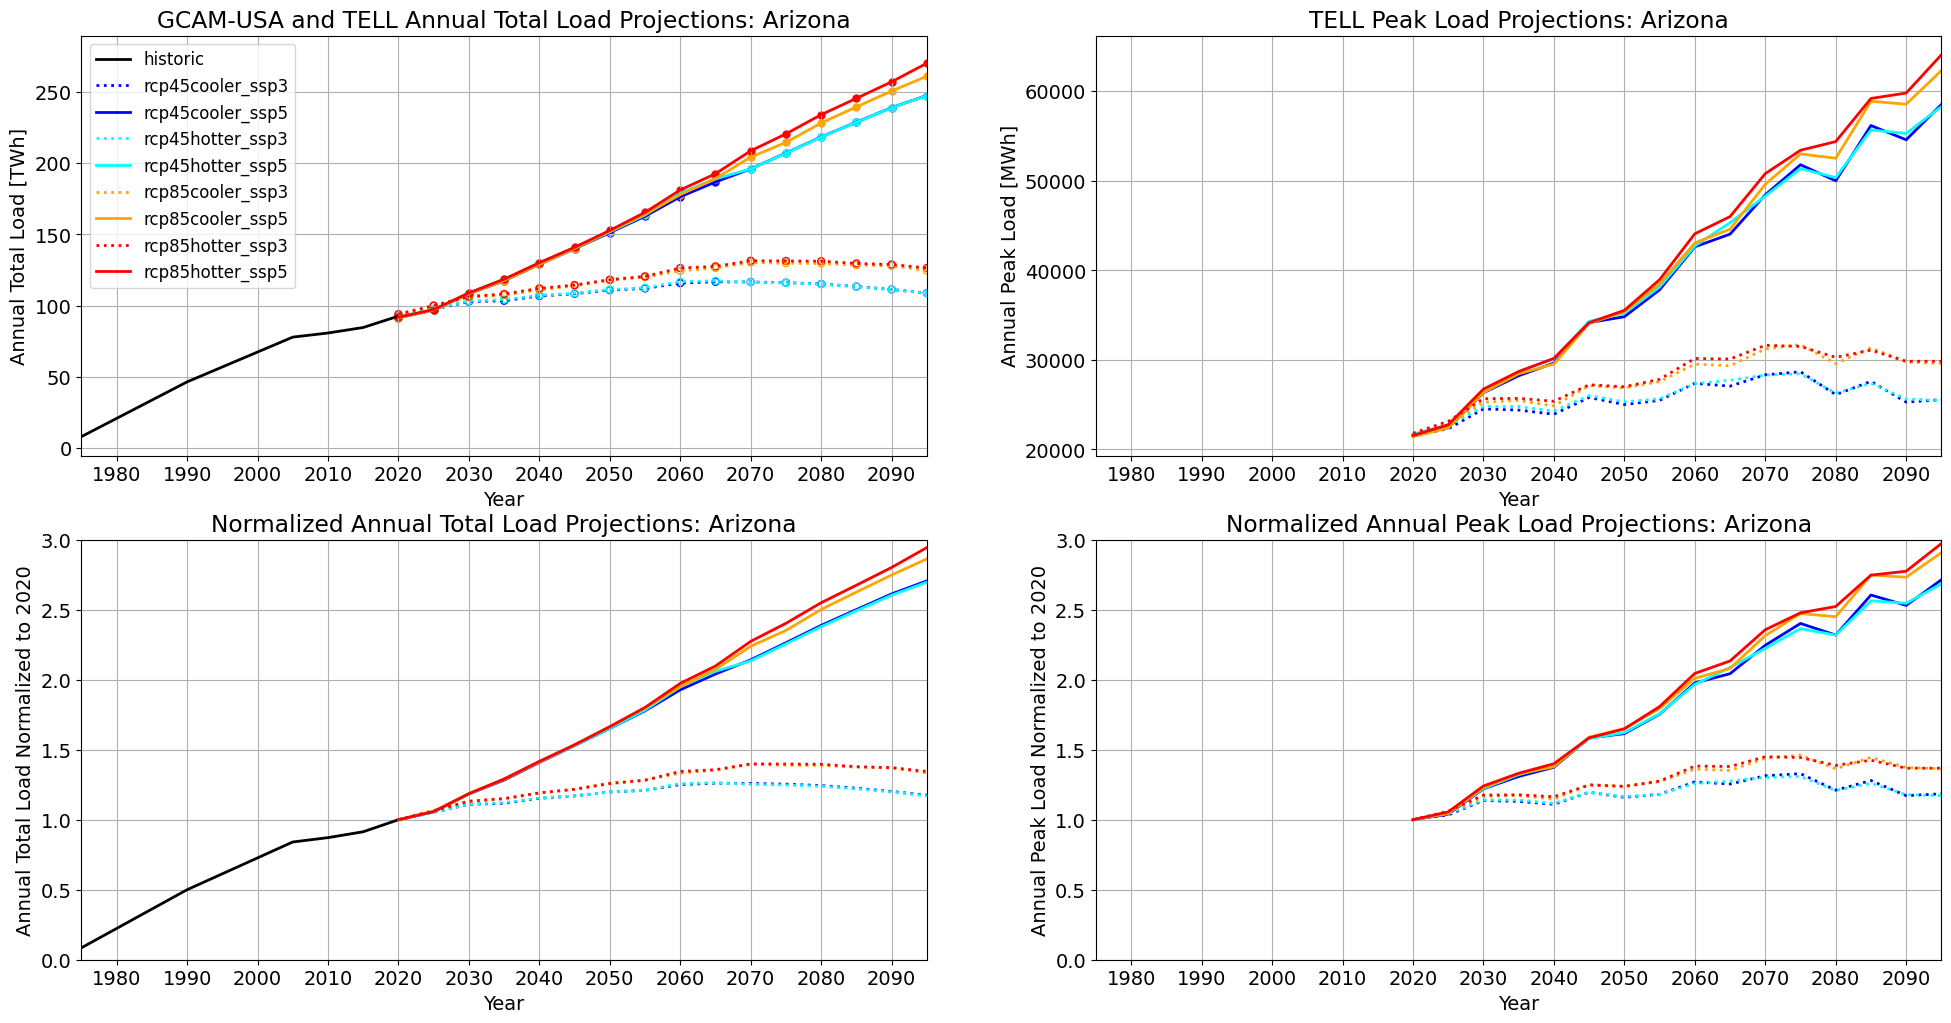

In [72]:
plot_load_time_series(state_name = 'Arizona', 
                      state_abbreviation = 'AZ', 
                      data_input_dir = data_output_dir, 
                      image_output_dir = image_output_dir, 
                      image_resolution = 300, 
                      save_images = True)
